In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import umap.umap_ as umap

# Standardization

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("Breast_cancer_data.csv")
numerical = ["mean_radius", "mean_texture", "mean_perimeter", "mean_area", "mean_smoothness"] 

X_train, X_test, y_train, y_test = train_test_split(data[numerical], data["diagnosis"], test_size=0.3, random_state=42, stratify=data["diagnosis"])

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=numerical)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numerical)

# Principal Component Analysis

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

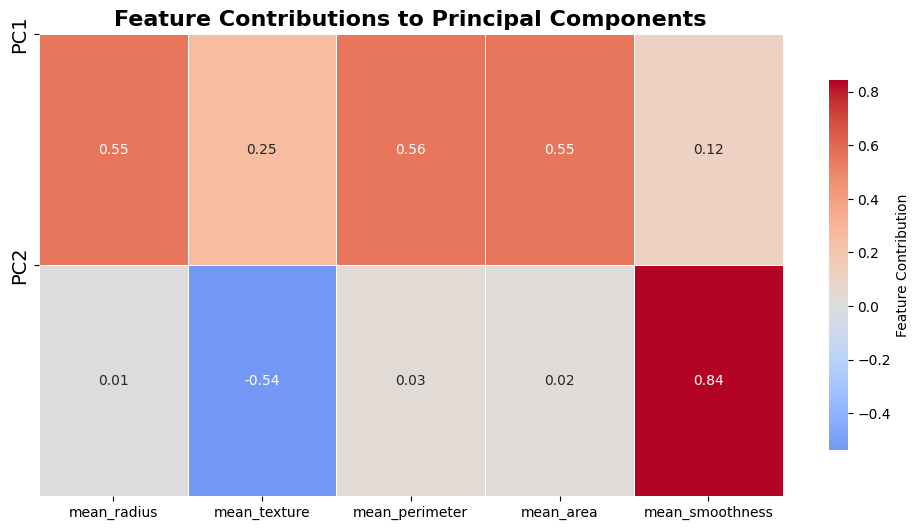

In [4]:
df_comp = pd.DataFrame(pca.components_,  columns=numerical)

plt.figure(figsize=(12,6))

sns.heatmap(df_comp, annot=True, fmt=".2f", cmap="coolwarm",center=0, linewidth=0.5, 
            cbar_kws={"shrink": 0.8, "label": "Feature Contribution"}
    )

plt.yticks(ticks=np.arange(len(["PC1", "PC2"])), labels=["PC1", "PC2"], fontsize=14)
plt.title("Feature Contributions to Principal Components", fontsize=16, fontweight="bold")

plt.show()


# Multidimensional Scaling (MDS)

In [5]:
X = data[numerical]
y = data["diagnosis"]

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

### MDS with 2 components

In [6]:
from sklearn.manifold import MDS

mds_2d = MDS(n_components=2, random_state=42, dissimilarity="euclidean")

X_mds_2d = mds_2d.fit_transform(X_scaled)

### MDS with 3 components

In [7]:
from sklearn.manifold import MDS

mds_3d = MDS(n_components=3, random_state=42, dissimilarity="euclidean")

X_mds_3d = mds_3d.fit_transform(X_scaled)

In [8]:

# 3 components gave less stress than 2 or 4:
print("MDS Stress in 2d:", mds_2d.stress_)
print("MDS Stress in 3d:", mds_3d.stress_)

MDS Stress in 2d: 30395.201077184163
MDS Stress in 3d: 21.21697790653023


# t-SNE

### t-SNE with 2 components

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=100)
X_tsne_2d = tsne.fit_transform(X_scaled)

In [10]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

perplexities = [5, 10, 30, 50, 100]

results = []

for perp in perplexities:
    tsne_2d = TSNE(n_components=2, perplexity=perp, random_state=42)
    X_tsne_2d = tsne_2d.fit_transform(X_scaled) 

    tsne_3d = TSNE(n_components=3, perplexity=perp, random_state=42)
    X_tsne_3d = tsne_3d.fit_transform(X_scaled)

    silhouette_2d = silhouette_score(X_tsne_2d, y)
    silhouette_3d = silhouette_score(X_tsne_3d, y)
    
    db_2d = davies_bouldin_score(X_tsne_2d, y)
    db_3d = davies_bouldin_score(X_tsne_3d, y)
    
    ch_2d = calinski_harabasz_score(X_tsne_2d, y)
    ch_3d = calinski_harabasz_score(X_tsne_3d, y)

    results.append([perp, silhouette_2d, silhouette_3d, db_2d, db_3d, ch_2d, ch_3d])

tsne_results = pd.DataFrame(results, columns=["Perplexity", "Silhouette 2D", "Silhouette 3D", 
                                            "Davies-Bouldin 2D", "Davies-Bouldin 3D",
                                            "Calinski-Harabasz 2D", "Calinski-Harabasz 3D"])
tsne_results

,Perplexity,Silhouette 2D,Silhouette 3D,Davies-Bouldin 2D,Davies-Bouldin 3D,Calinski-Harabasz 2D,Calinski-Harabasz 3D
0,5,0.321512,0.310015,1.127473,1.191703,327.923096,321.525726
1,10,0.375611,0.330810,0.971572,1.121509,458.829132,366.672333
2,30,0.391420,0.340142,0.935448,1.094501,499.424866,380.085663
3,50,0.405952,0.356844,0.901815,1.057690,523.275940,417.896881
4,100,0.436198,0.365706,0.848861,1.034774,601.769592,434.022247


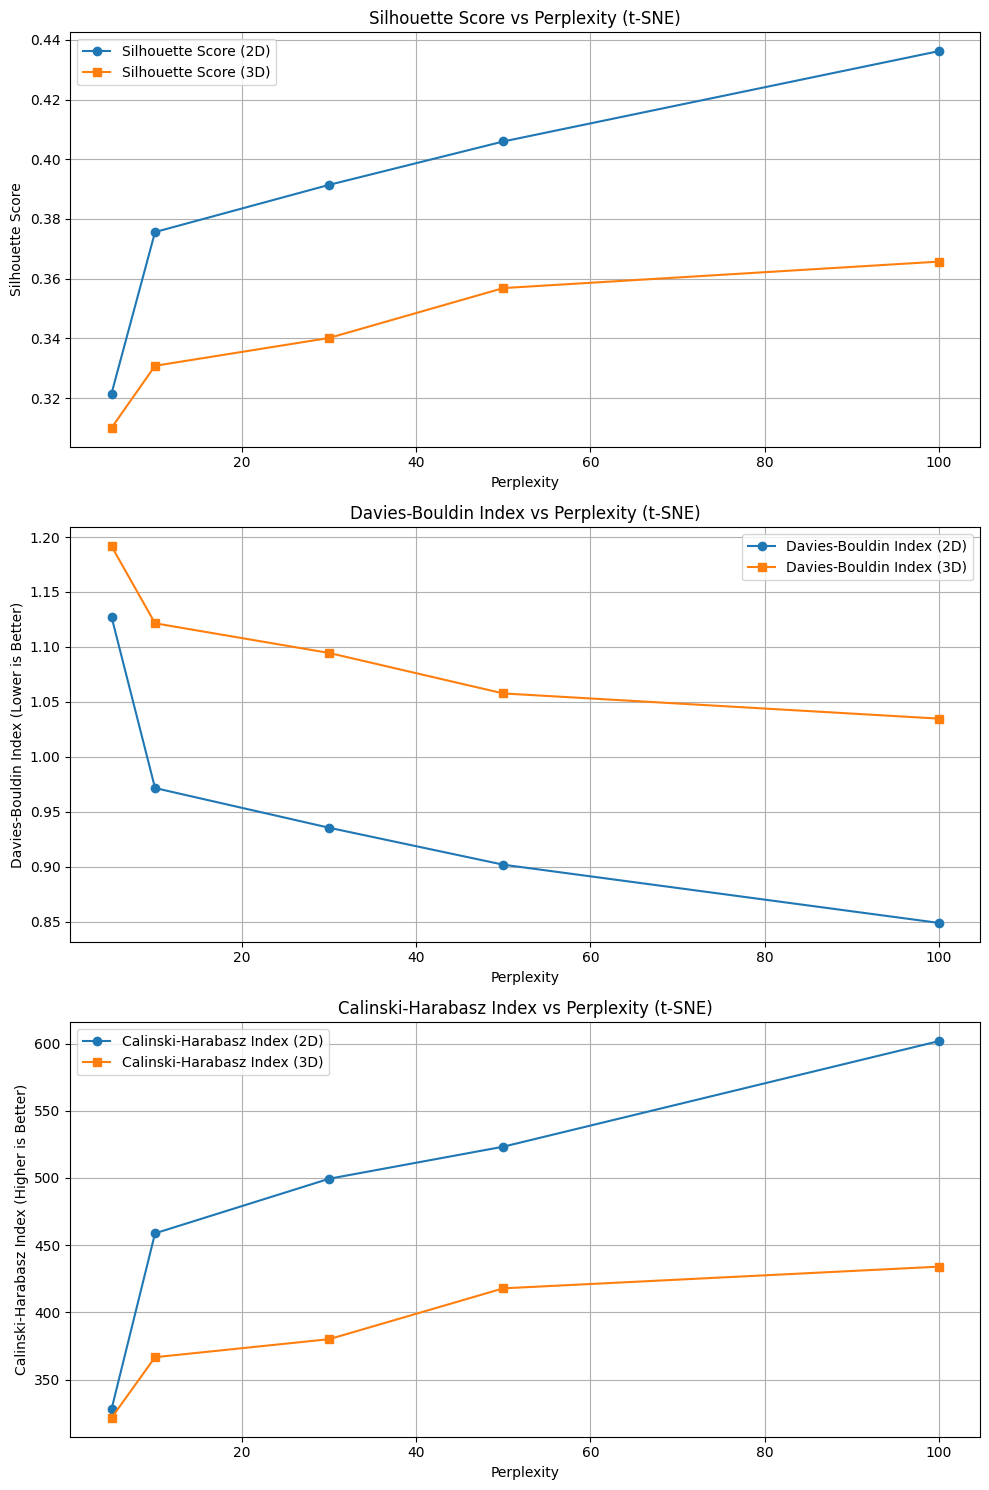

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot Silhouette Score
axes[0].plot(tsne_results["Perplexity"], tsne_results["Silhouette 2D"], marker="o", label="Silhouette Score (2D)")
axes[0].plot(tsne_results["Perplexity"], tsne_results["Silhouette 3D"], marker="s", label="Silhouette Score (3D)")
axes[0].set_xlabel("Perplexity")
axes[0].set_ylabel("Silhouette Score")
axes[0].set_title("Silhouette Score vs Perplexity (t-SNE)")
axes[0].legend()
axes[0].grid(True)

# Plot Davies-Bouldin Index
axes[1].plot(tsne_results["Perplexity"], tsne_results["Davies-Bouldin 2D"], marker="o", label="Davies-Bouldin Index (2D)")
axes[1].plot(tsne_results["Perplexity"], tsne_results["Davies-Bouldin 3D"], marker="s", label="Davies-Bouldin Index (3D)")
axes[1].set_xlabel("Perplexity")
axes[1].set_ylabel("Davies-Bouldin Index (Lower is Better)")
axes[1].set_title("Davies-Bouldin Index vs Perplexity (t-SNE)")
axes[1].legend()
axes[1].grid(True)

# Plot Calinski-Harabasz Index
axes[2].plot(tsne_results["Perplexity"], tsne_results["Calinski-Harabasz 2D"], marker="o", label="Calinski-Harabasz Index (2D)")
axes[2].plot(tsne_results["Perplexity"], tsne_results["Calinski-Harabasz 3D"], marker="s", label="Calinski-Harabasz Index (3D)")
axes[2].set_xlabel("Perplexity")
axes[2].set_ylabel("Calinski-Harabasz Index (Higher is Better)")
axes[2].set_title("Calinski-Harabasz Index vs Perplexity (t-SNE)")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


# UMAP

### UMAP with 2 components

In [ ]:
umap_2d = umap.UMAP(n_components=2, random_state=42)
X_umap_2d = umap_2d.fit_transform(X_scaled)

### UMAP with 3 components

In [ ]:
umap_3d = umap.UMAP(n_components=3, random_state=42)
X_umap_3d = umap_3d.fit_transform(X_scaled)

In [14]:
silhouette_2d = silhouette_score(X_umap_2d, y)
silhouette_3d = silhouette_score(X_umap_3d, y)

print("Silhouette 2d = ", silhouette_2d)
print("Silhouette 3d = ", silhouette_3d)

Silhouette 2d =  0.39916584
Silhouette 3d =  0.40732145


# Final Comparison

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_mds_train, X_mds_test, y_train, y_test = train_test_split(X_mds_3d, y, test_size=0.3, random_state=42)
X_tsne_train, X_tsne_test, _, _ = train_test_split(X_tsne_2d, y, test_size=0.3, random_state=42)
X_umap_train, X_umap_test, _, _ = train_test_split(X_umap_2d, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)

datasets = {
    "PCA (2D)": (X_train_pca, X_test_pca),
    "MDS (3D)": (X_mds_train, X_mds_test),
    "t-SNE (2D)": (X_tsne_train, X_tsne_test),
    "UMAP (3D)": (X_umap_train, X_umap_test)
}

results = []

for name, (X_train, X_test) in datasets.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append([name, acc])

comparison_df = pd.DataFrame(results, columns=["Method", "Classification Accuracy"])

comparison_df

,Method,Classification Accuracy
0,PCA (2D),0.543860
1,MDS (3D),0.935673
2,t-SNE (2D),0.929825
3,UMAP (3D),0.918129


### Plotting the comparison in 2D

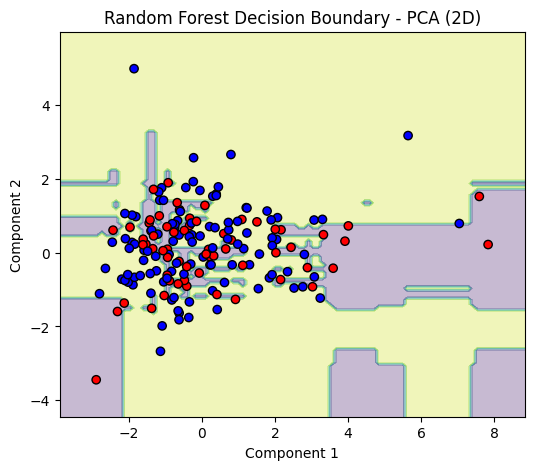

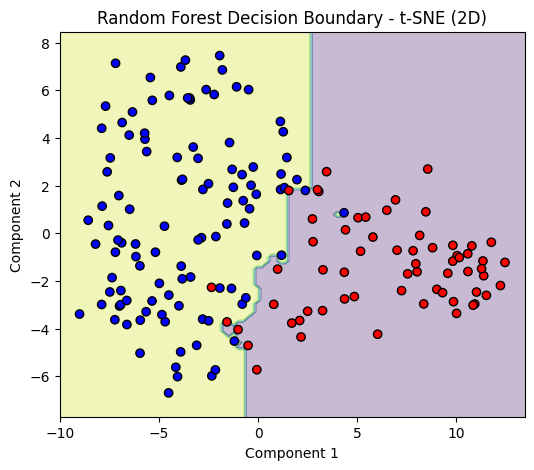

In [16]:
colors = {0: "red", 1: "blue"} 

def plot_decision_boundary(X, y, method_name):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, y)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y.map(colors), edgecolor="k")
    plt.title(f"Random Forest Decision Boundary - {method_name}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

plot_decision_boundary(X_test_pca, y_test, "PCA (2D)")

plot_decision_boundary(X_tsne_test, y_test, "t-SNE (2D)")


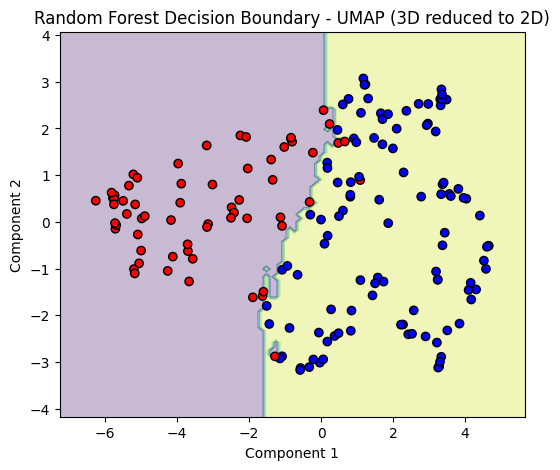

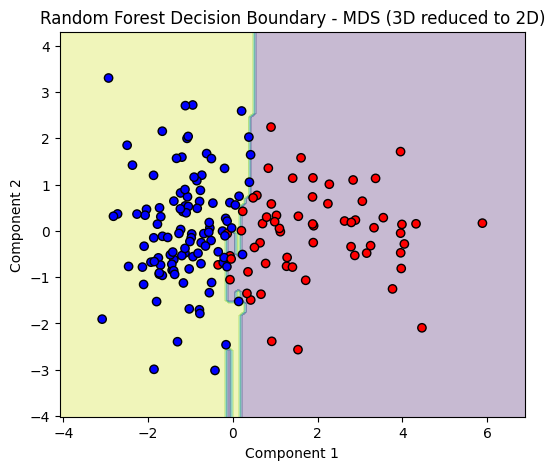

In [17]:
pca_umap = PCA(n_components=2)
X_umap_2d = pca_umap.fit_transform(X_umap_test)
plot_decision_boundary(X_umap_2d, y_test, "UMAP (3D reduced to 2D)")

pca_mds = PCA(n_components=2)
X_mds_2d = pca_mds.fit_transform(X_mds_test)
plot_decision_boundary(X_mds_2d, y_test, "MDS (3D reduced to 2D)")
